In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import subplot

# 设置中文字体（SimHei）
matplotlib.rcParams['font.family'] = 'SimHei'
# 防止负号显示为方块
matplotlib.rcParams['axes.unicode_minus'] = False


In [2]:
#Scikit-learn分类任务完整流程指南
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import joblib
import time

In [3]:
from pathlib import Path
train_data= pd.read_csv(Path("datasets/titanic/train.csv"))
test_data= pd.read_csv(Path("datasets/titanic/test.csv"))


In [5]:
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [21]:
print("\n缺失值统计:")
print(train_data.isnull().sum())


缺失值统计:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [22]:
# 特征选择与目标变量定义
X = train_data.drop(['Survived','PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = train_data["Survived"]


In [30]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42
)

In [33]:
# 定义数值和类别特征
num_cols = ['Age', 'Fare', 'SibSp', 'Parch']
cat_cols = ['Pclass', 'Sex', 'Embarked'] #Pclass为舱室等级，与num没有关系


In [40]:
#数据预处理
num = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

cat = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown='ignore')),
    ])

preprocessor = ColumnTransformer(
    [
        ("num", num, num_cols),
        ("cat", cat, cat_cols),
    ]
)

In [50]:
# 定义模型管道
models  ={
      '逻辑回归': Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=1000, random_state=42))
       ]),
       '随机森林': Pipeline([
           ('preprocessor', preprocessor),
           ('classifier', RandomForestClassifier(random_state=42))
       ]),
}



In [69]:
#训练 + 评估
def evaluate(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    print(f"{name} 验证集准确率: {accuracy_score(y_te, y_pred):.4f}")
    print(classification_report(y_te, y_pred))
    print("-" * 100)

for name, model in models.items():
    evaluate(name, model, X_train, y_train, X_test, y_test)

逻辑回归 验证集准确率: 0.7989
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

----------------------------------------------------------------------------------------------------
随机森林 验证集准确率: 0.8268
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

----------------------------------------------------------------------------------------------------


In [70]:
#param_grid调优
param_grids = {
    '逻辑回归': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['liblinear']
    },
    '随机森林': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 3, 5, 7],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
}


In [72]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate(name, model, X_tr, y_tr, X_te, y_te, param_grid):
    grid = GridSearchCV(
        model,
        param_grid,
        cv=10,
        n_jobs=-1,
        scoring='accuracy',
        verbose=2
    )
    grid.fit(X_tr, y_tr)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_te)

    print(f"{name} 验证集准确率: {accuracy_score(y_te, y_pred):.4f}")
    print(classification_report(y_te, y_pred))
    print("-" * 100)

# 直接调用，无需 best_models
for name, model in models.items():
    evaluate(name, model, X_train, y_train, X_test, y_test, param_grids[name])

Fitting 10 folds for each of 4 candidates, totalling 40 fits
逻辑回归 验证集准确率: 0.7989
              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

----------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
随机森林 验证集准确率: 0.8101
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.83      0.68      0.75        74

    accuracy                           0.81       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

-------------------------------------------------------------------------------

In [52]:
#pansas探索
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [53]:
# 基本数据概览
print("数据集形状:", train_data.shape)
print("\n前5行数据:")
print(train_data.head())
print("\n数据统计信息:")
print(train_data.describe())


数据集形状: (891, 15)

前5行数据:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  child  Child  FamilySize  
0      0         A/5 21171   7.2500   NaN        S  False  False           2  
1      0          PC 17599  71.2833   C85        C  False  False           2  
2      0  STON/O2. 3101282   7.9250   NaN        S  False 

In [54]:
# 性别与存活率关系
Survived_gender = train_data.groupby('Sex')['Survived'].mean()
Survived_gender

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [14]:
# 船舱等级分析
Survival_Pclass = train_data.groupby('Pclass')['Survived'].mean()
Survival_Pclass

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [47]:
train_data['Age'].fillna(train_data['Age'].median())


0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    28.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [33]:
# 性别分别为男性，女性年龄的中位数
Gender_Women = train_data[train_data["Sex"]=="female"]["Age"].agg(['mean','median'])
Gender_Man = train_data[train_data["Sex"]=="male"]["Age"].agg(['mean','median'])
print(f"女性：{Gender_Women} 男性: {Gender_Man}")


女性：mean      27.915709
median    27.000000
Name: Age, dtype: float64 男性: mean      30.726637
median    29.000000
Name: Age, dtype: float64


In [20]:
# 儿童存活率分析
train_data['Child'] = train_data['Age'] < 18
Survival_Child = train_data.groupby('Child')['Survived'].agg(
    ['mean', 'median']
)
Survival_Child

,mean,median
Child,,
False,0.361183,0.0
True,0.539823,1.0


In [43]:
# 家庭规模影响
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
Survival_family = train_data.groupby('FamilySize')['Survived'].agg(['mean', 'median'])
Survival_family

,mean,median
FamilySize,,
1,0.303538,0.0
2,0.552795,1.0
3,0.578431,1.0
4,0.724138,1.0
5,0.200000,0.0
6,0.136364,0.0
7,0.333333,0.0
8,0.000000,0.0
11,0.000000,0.0


In [45]:
# 登船港口分析
Survival_Port = train_data.groupby('Embarked')['Survived'].agg(['mean', 'median'])
Survival_Port

,mean,median
Embarked,,
C,0.553571,1.0
Q,0.389610,0.0
S,0.336957,0.0


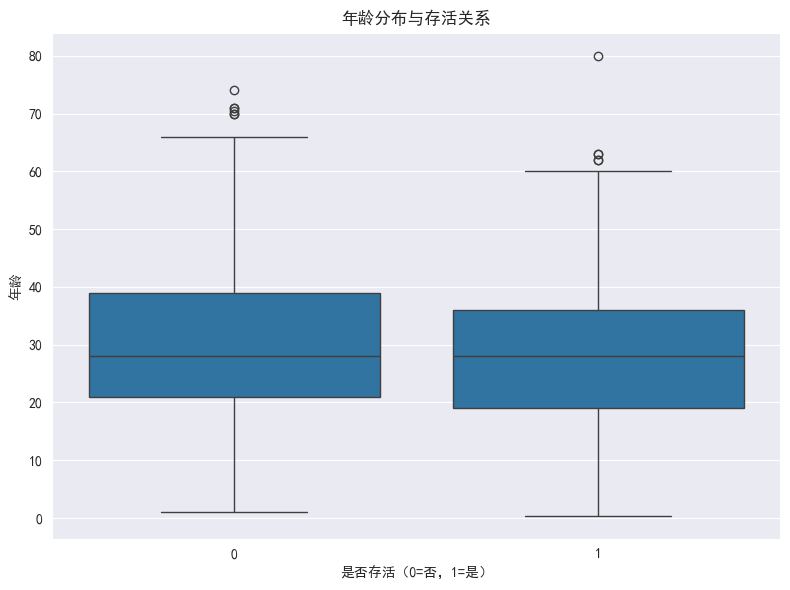

In [9]:
#年龄分布与存活 =
plt.figure(figsize=(8, 6))

sns.boxplot(data =train_data,x='Survived', y='Age')
plt.title('年龄分布与存活关系')
plt.xlabel('是否存活（0=否，1=是）')
plt.ylabel('年龄')


plt.tight_layout()
plt.show()

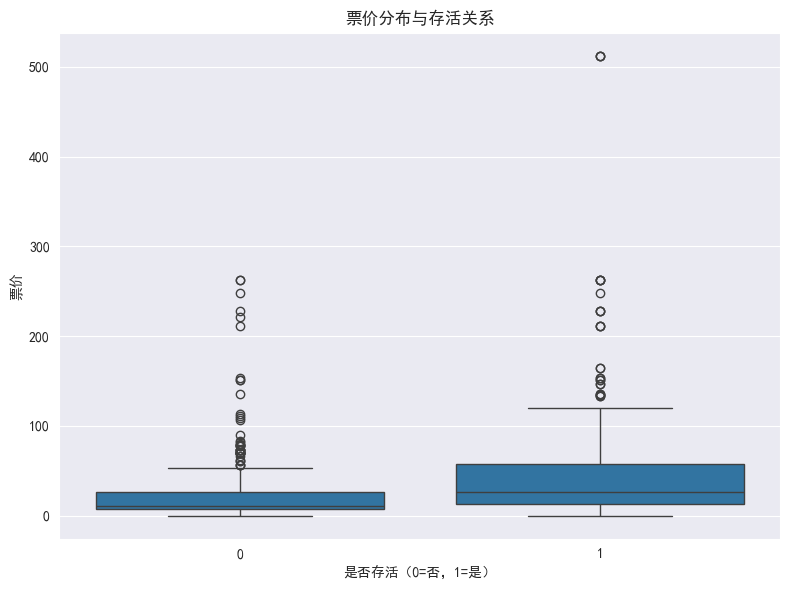

In [11]:
# 票价与存活关系
plt.figure(figsize=(8, 6))
sns.boxplot(data =train_data,x='Survived', y='Fare')
plt.title('票价分布与存活关系')
plt.xlabel('是否存活（0=否，1=是）')
plt.ylabel('票价')

plt.tight_layout()
plt.show()


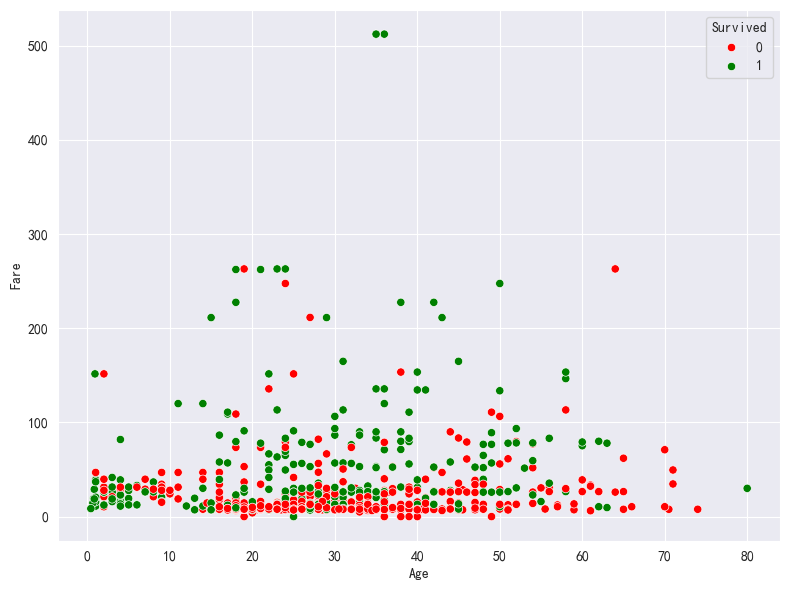

In [12]:
# 年龄、票价和存活状态
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=train_data,
    x='Age',
    y='Fare',
    hue='Survived',
    palette={0: 'red', 1: 'green'},

)

plt.tight_layout()
plt.show()
